# Topic Modelling

 Topic modelling is the process in which we try uncover abstract themes or "topics" based on the underlying documents and words in a corpus of text.

# Imports

In [ ]:
import matplotlib.pyplot as plt
plt.rcdefaults()
import nltk
from nltk.stem import WordNetLemmatizer
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS

In [43]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Read Data

In [5]:
train_data = pd.read_csv('data/train.csv')
print('Train Shape: ' + str(train_data.shape))
train_data.head()

Train Shape: (19579, 3)


,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


# Exploratory Data Analysis

Visualize some basic statistics in the data, like the distribution of entries for each author.

In [ ]:
z = {'EAP': 'Edgar Allen Poe', 'MWS': 'Mary Shelley', 'HPL': 'HP Lovecraft'}


plt.bar(train_data['author'].map(z).unique(), train_data['author'].value_counts().values, align='center', alpha=0.5)
plt.title('Target variable distribution')

plt.show()

In [ ]:
all_words = train_data['text'].str.split(expand=True).unstack().value_counts()

plt.figure(figsize=(20, 20))
plt.bar(all_words.index.values[2:50], all_words.values[2:50], align='center', alpha=0.5)
plt.title('Top 50 (Uncleaned) Word frequencies in the training dataset')

plt.show()

These words are all so commonly occuring words which you could find just anywhere else. Therefore we must find some way to preprocess our dataset first to strip out all these commonly occurring words which do not bring much to the table.

## WordClouds to visualise each author's work

A word cloud (as the name suggests) is an image that is made up of a mixture of distinct words which may make up a text or book and where the size of each word is proportional to its word frequency in that text (number of times the word appears). Here instead of dealing with an actual book or text, our words can simply be taken from the column "text"

In [ ]:
# Store the text of each author in a Python list
eap = train_data[train_data['author'] == 'EAP']['text'].values
hpl = train_data[train_data['author'] == 'HPL']['text'].values
mws = train_data[train_data['author'] == 'MWS']['text'].values

In [ ]:
wc = WordCloud(background_color="black", max_words=10000, stopwords=STOPWORDS, max_font_size= 40)

(-0.5, 399.5, 199.5, -0.5)

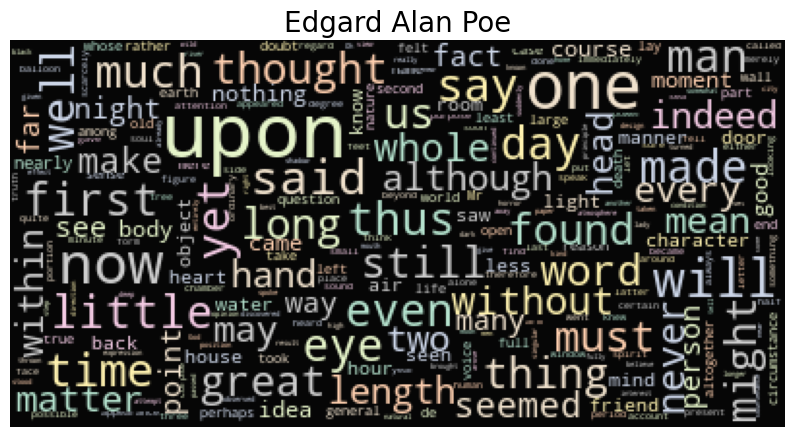

In [35]:
# The wordcloud of Edgard Alan Poe
wc = WordCloud(background_color="black", max_words=10000, stopwords=STOPWORDS, max_font_size= 40)
wc.generate(" ".join(eap))

#Show the cloud 
plt.figure(figsize=(10,10))
plt.title("Edgard Alan Poe", fontsize=20)
plt.imshow(wc.recolor( colormap= 'Pastel2' , random_state=17), alpha=0.98)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

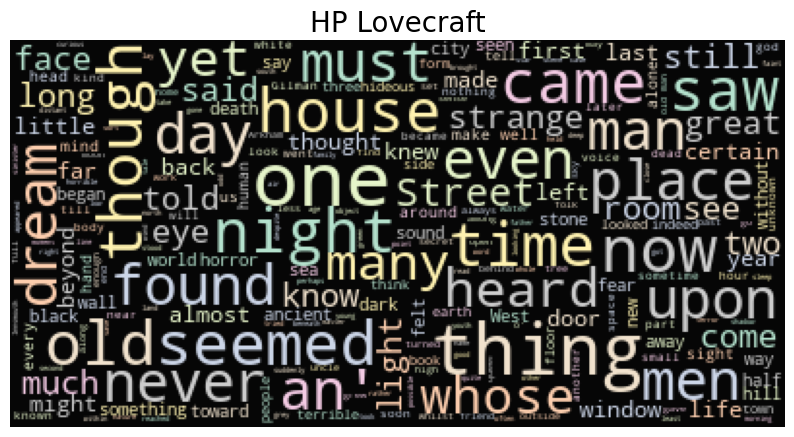

In [36]:
# The wordcloud of Cthulhu/squidy thing for HP Lovecraft
wc = WordCloud(background_color="black", max_words=10000, stopwords=STOPWORDS, max_font_size= 40)
wc.generate(" ".join(hpl))

#Show the cloud 
plt.figure(figsize=(10,10))
plt.title("HP Lovecraft", fontsize=20)
plt.imshow(wc.recolor( colormap= 'Pastel2' , random_state=17), alpha=0.98)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

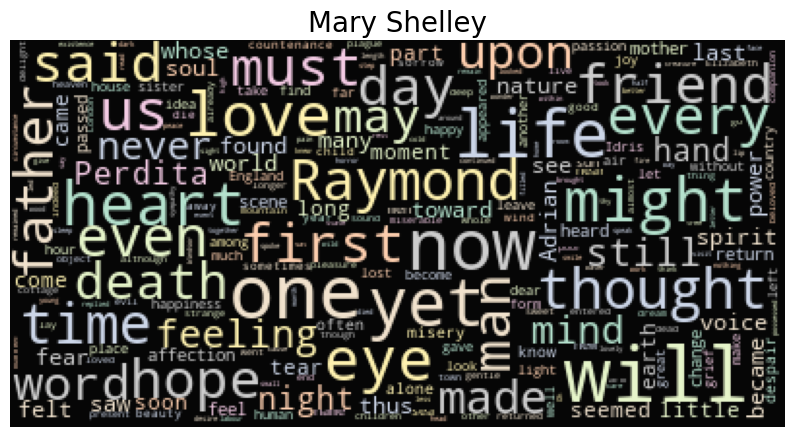

In [32]:
wc = WordCloud(background_color="black", max_words=10000, stopwords=STOPWORDS, max_font_size= 40)
wc.generate(" ".join(mws))

#Show the cloud 
plt.figure(figsize=(10,10))
plt.title("Mary Shelley", fontsize=20)
plt.imshow(wc.recolor( colormap= 'Pastel2' , random_state=17), alpha=0.98)
plt.axis('off')

# Natural Language Processing

## Tokenization

Taking a sequence of characters in a given document and dicing it up into its individual constituent pieces, which are the eponymous "tokens" of this method. One could loosely think of them as singular words in a sentence.

In [41]:
# EXAMPLE
first_text = train_data.iloc[0]['text']
first_text

'This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.'

In [44]:
first_text_list = nltk.word_tokenize(first_text)
print(first_text_list)

['This', 'process', ',', 'however', ',', 'afforded', 'me', 'no', 'means', 'of', 'ascertaining', 'the', 'dimensions', 'of', 'my', 'dungeon', ';', 'as', 'I', 'might', 'make', 'its', 'circuit', ',', 'and', 'return', 'to', 'the', 'point', 'whence', 'I', 'set', 'out', ',', 'without', 'being', 'aware', 'of', 'the', 'fact', ';', 'so', 'perfectly', 'uniform', 'seemed', 'the', 'wall', '.']


However as you can see from this first attempt at tokenization, the segregation of the sentence into its individual elements (or terms) is not entirely accurate

In [45]:
first_text_list = nltk.word_tokenize(first_text)
print(first_text_list)

['This', 'process', ',', 'however', ',', 'afforded', 'me', 'no', 'means', 'of', 'ascertaining', 'the', 'dimensions', 'of', 'my', 'dungeon', ';', 'as', 'I', 'might', 'make', 'its', 'circuit', ',', 'and', 'return', 'to', 'the', 'point', 'whence', 'I', 'set', 'out', ',', 'without', 'being', 'aware', 'of', 'the', 'fact', ';', 'so', 'perfectly', 'uniform', 'seemed', 'the', 'wall', '.']


## Stopwords removal

Stopwords are generally words that appear so commonly and at such a high frequency in the corpus that they don't actually contribute much to the learning or predictive process as a learning model would fail to distinguish it from other texts. 

Stopwords include terms such as "to" or "the" and therefore, it would be to our benefit to remove them during the pre-processing phase.

In [ ]:
stopwords = nltk.corpus.stopwords.words('english')

In [50]:
first_text_list_cleaned = [word for word in first_text_list if word.lower() not in stopwords]
print(first_text_list_cleaned)
print("="*90)
print("Length of original list: " + str(len(first_text_list)) + " words")
print("Length of list after stopwords removal: " + str(len(first_text_list_cleaned)) + " words")

['process', ',', 'however', ',', 'afforded', 'means', 'ascertaining', 'dimensions', 'dungeon', ';', 'might', 'make', 'circuit', ',', 'return', 'point', 'whence', 'set', ',', 'without', 'aware', 'fact', ';', 'perfectly', 'uniform', 'seemed', 'wall', '.']
Length of original list: 48 words
Length of list after stopwords removal: 28 words


## Stemming

The work at this stage attempts to reduce as many different variations of similar words into a single term ( different branches all reduced to single word stem). Therefore if we have "running", "runs" and "run", you would really want these three distinct words to collapse into just the word "run". (However of course you lose granularity of the past, present or future tense).

There are various stemmers algorithms such as the Porter stemming algorithm, the lancaster stemmer and the Snowball stemmer. In the following example, I will create a porter stemmer instance as follows:

In [ ]:
stemmer = nltk.stem.PorterStemmer()

In [52]:
print("The stemmed form of running is: {}".format(stemmer.stem("running")))
print("The stemmed form of runs is: {}".format(stemmer.stem("runs")))
print("The stemmed form of run is: {}".format(stemmer.stem("run")))

The stemmed form of running is: run
The stemmed form of runs is: run
The stemmed form of run is: run


However there is one flaw with stemming and that is the fact that the process involves quite a crude heuristic in chopping off the ends of words in the hope of reducing a particular word into a human recognizable base form. Therefore this process does not take into account vocabulary or word forms when collapsing words

In [53]:
print("The stemmed form of leaves is: {}".format(stemmer.stem("leaves")))

The stemmed form of leaves is: leav


## Lemmatization

Unlike a stemmer, lemmatizing the dataset aims to reduce words based on an actual dictionary or vocabulary (the Lemma) and therefore will not chop off words into stemmed forms that do not carry any lexical meaning. 

In [56]:
lemm = WordNetLemmatizer()
print("The lemmatized form of leaves is: {}".format(lemm.lemmatize("leaves")))

The lemmatized form of leaves is: leaf


## Text Vectorization
Text vectorization, or feature extraction, is the process of converting text into a numerical representation that can then be used as an input for a machine learning model or some other mathematical algorithm.  This is typically the first and most important step of any NLP task.  This notebook includes step-by-step instructions for performing a variety of text vectorization techniques on text documents.  These techniques include:

* Tf-idf
* Bag-of-words
* Hashing
* Sequence IDs
* One-hot encodings
* Word2ve

### Bag of Words

A bag-of-words vectorizer describes the occurence of words wothin a document. It first defines a limited vocabulary of known words and then for each document mesures the presence of these known words. It can either construct feature vector with the counts of each vocabulary found in the document or, in the binary case, simply indicate whether or not each vocabulary word is found in the document. Thus the number of features in the vector is equal to the number of words in the known vocabulary.

e.g. 

    document: the brown fox jumped over the brown dog

    vocabulary: [a, the, of, brown, fox, house, jumped, over, with, dog]

    count feature vector: [0, 2, 0, 2, 1, 0, 1, 1, 0, 1]
    
    binary feature vector: [0, 1, 0, 1, 1, 0, 1, 1, 0, 1]

#### BoW Example
**Fitting the vectorizer to the dataset**

Here we initialize and create a simple term frequency object via the CountVectorizer function simply called "vectorizer".  Here "min_df" in the parameter refers to the minimum document frequency and the vectorizer will simply drop all words that occur less than that value set (either integer or in fraction form).

In [ ]:
# Defining our sentence
sentence = ["I love to eat Burgers", 
            "I love to eat Fries"]
vectorizer = CountVectorizer(min_df=0)
sentence_transform = vectorizer.fit_transform(sentence)

In [60]:
print("The features are:\n {}".format(vectorizer.get_feature_names()))
print("\nThe vectorized array looks like:\n {}".format(sentence_transform.toarray()))

The features are:
 ['burgers', 'eat', 'fries', 'love', 'to']

The vectorized array looks like:
 [[1 1 0 1 1]
 [0 1 1 1 1]]


# Topic Modelling



In [ ]:
# Define helper function to print top words
def print_top_words(model, feature_names, n_top_words):
    for index, topic in enumerate(model.components_):
        message = "\nTopic #{}:".format(index)
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1 :-1]])
        print(message)
        print("="*70)

When you vectorize the raw text with CountVectorizer, the dual stages of tokenizing and stopwords filtering are automatically included as a high-level component.

Unfortunately, there is no built-in lemmatizer in the vectorizer so we are left with a couple of options. Either implementing it separately everytime before feeding the data for vectorizing or somehow extend the sklearn implementation to include this functionality. Luckily for us, we have the latter option where we can extend the CountVectorizer class by overwriting the "build_analyzer" method as follows:

In [ ]:
lemm = WordNetLemmatizer()
class LemmaCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(LemmaCountVectorizer, self).build_analyzer()
        return lambda doc: (lemm.lemmatize(w) for w in analyzer(doc))

In [ ]:
tf_vectorizer = LemmaCountVectorizer(max_df=0.95, 
                                     min_df=2,
                                     stop_words='english',
                                     decode_error='ignore')

In [ ]:
text = train_data['text'].values
tf = tf_vectorizer.fit_transform(text)

With the removal of stopwords, the remaining words seem much more meaningful where you can see that all the stopwords in the earlier term frequency plot.

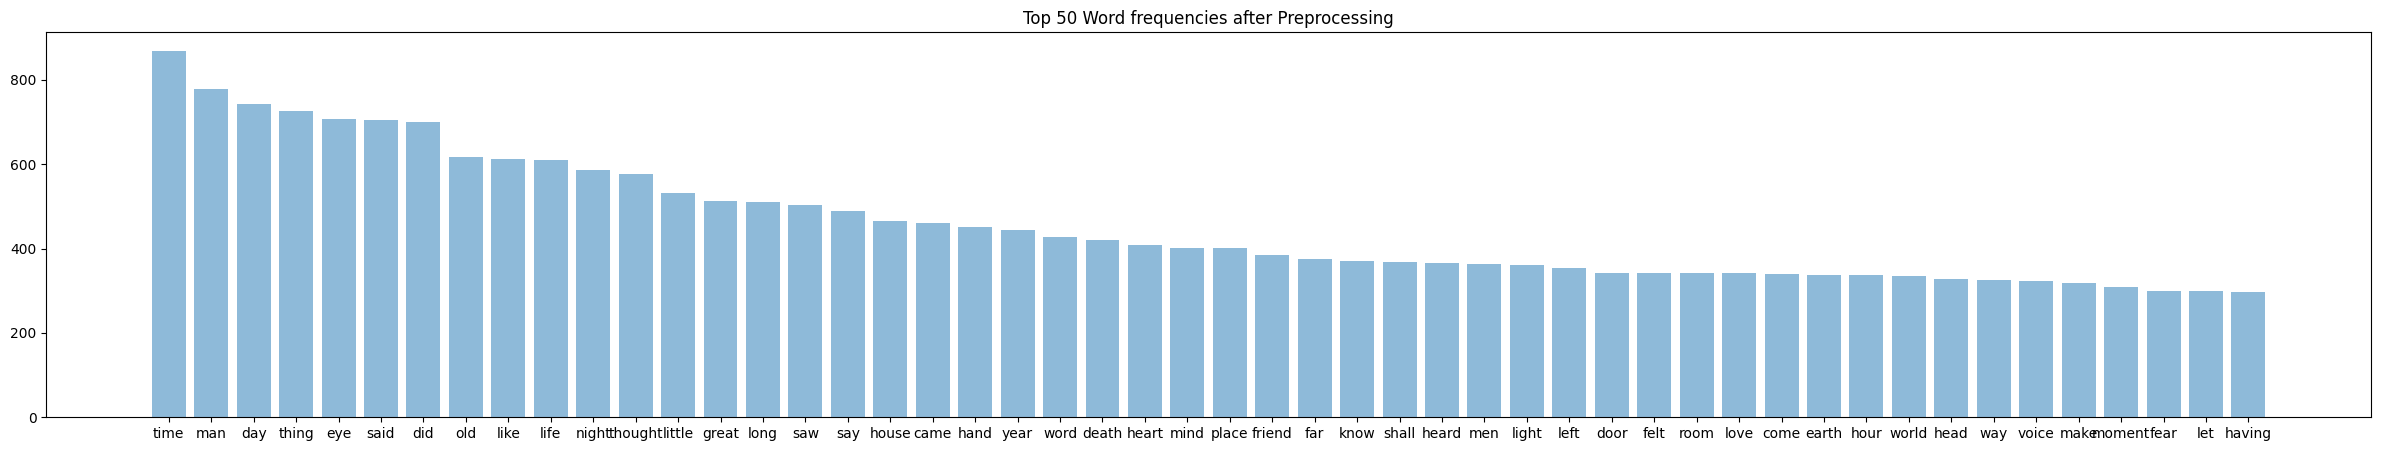

In [78]:
feature_names = tf_vectorizer.get_feature_names()
count_vec = np.asarray(tf.sum(axis=0)).ravel()
zipped = list(zip(feature_names, count_vec))
x, y = (list(x) for x in zip(*sorted(zipped, key=lambda x: x[1], reverse=True)))

# Now I want to extract out on the top 15 and bottom 15 words
Y = np.concatenate([y[0:15], y[-16:-1]])
X = np.concatenate([x[0:15], x[-16:-1]])

plt.figure(figsize=(30,5))
plt.bar(x[0:50], y[0:50], align='center', alpha=0.5)
plt.title("Top 50 Word frequencies after Preprocessing")
plt.show()

##  [Latent Dirichlet Allocation](https://towardsdatascience.com/light-on-math-machine-learning-intuitive-guide-to-latent-dirichlet-allocation-437c81220158)

In LDA, the modelling process revolves around three things: the text corpus, its collection of documents (D) and the words (W) in the documents. Therefore the algorithm attempts to uncover K topics from this corpus via the following way (illustrated by the diagram)

![](https://scikit-learn.org/stable/_images/lda_model_graph.png)

Model each topic $κ$,  via a Dirichlet prior distribution given by  $β_k$ :

Model each document $D$ by another Dirichlet distribution parameterized by $α$ :

Subsequently for document $D$, we generate a topic via a multinomial distribution which we then backtrack and use to generate the correspondings words related to that topic via another multinomial distribution.

The LDA algorithm first models documents via a mixture model of topics. From these topics, words are then assigned weights based on the probability distribution of these topics. It is this probabilistic assignment over words that allow a user of LDA to say how likely a particular word falls into a topic. Subsequently from the collection of words assigned to a particular topic, are we thus able to gain an insight as to what that topic may actually represent from a lexical point of view.

From a standard LDA model, there are really a few key parameters that we have to keep in mind and consider programmatically tuning before we invoke the model:

1. *n_components:* The number of topics that you specify to the model.
2. $α$ : This is the dirichlet parameter that can be linked to the document topic prior.
3. $β$ : This is the dirichlet parameter linked to the topic word prior.

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

In [ ]:
lda = LatentDirichletAllocation(n_components=11, max_iter=5,
                                learning_method = 'online',
                                learning_offset = 50.,
                                random_state = 0)

In [87]:
# Fit LDA to text
lda.fit(tf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=50.0,
                          max_doc_update_iter=100, max_iter=5,
                          mean_change_tol=0.001, n_components=11, n_jobs=None,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [88]:
#Topics generated by LDA
n_top_words = 40
print("Topics in LDA model: ")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

Topics in LDA model: 

Topic #0:mean night fact young return great human looking wonder countenance difficulty greater wife finally set possessed regard struck perceived act society law health key fearful mr exceedingly evidence carried home write lady various recall accident force poet neck conduct investigation

Topic #1:death love raymond hope heart word child went time good man ground evil long misery replied filled passion bed till happiness memory heavy region year escape spirit grief visit doe story beauty die plague making influence thou letter appeared power

Topic #2:left let hand said took say little length body air secret gave right having great arm thousand character minute foot true self gentleman pleasure box clock discovered point sought pain nearly case best mere course manner balloon fear head going

Topic #3:called sense table suddenly sympathy machine sens unusual labour thrown mist solution suppose specie movement whispered urged frequent wine hour appears ring tur

In [ ]:
first_topic = lda.components_[0]
second_topic = lda.components_[1]
third_topic = lda.components_[2]
fourth_topic = lda.components_[3]

In [ ]:
# Word Cloud visualizations of the topics
first_topic_words = [tf_feature_names[i] for i in first_topic.argsort()[:-50 - 1 :-1]]
second_topic_words = [tf_feature_names[i] for i in second_topic.argsort()[:-50 - 1 :-1]]
third_topic_words = [tf_feature_names[i] for i in third_topic.argsort()[:-50 - 1 :-1]]
fourth_topic_words = [tf_feature_names[i] for i in fourth_topic.argsort()[:-50 - 1 :-1]]

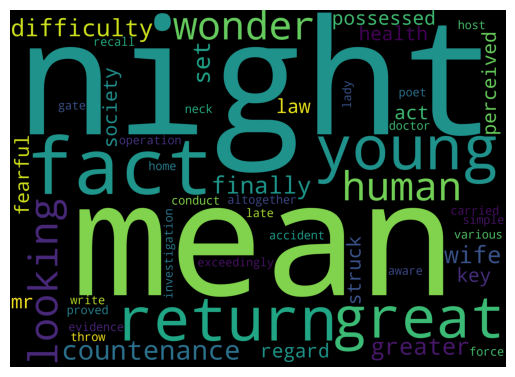

In [91]:
# FIRST TOPIC 
firstcloud = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          width=2500,
                          height=1800
                         ).generate(" ".join(first_topic_words))
plt.imshow(firstcloud)
plt.axis('off')
plt.show()

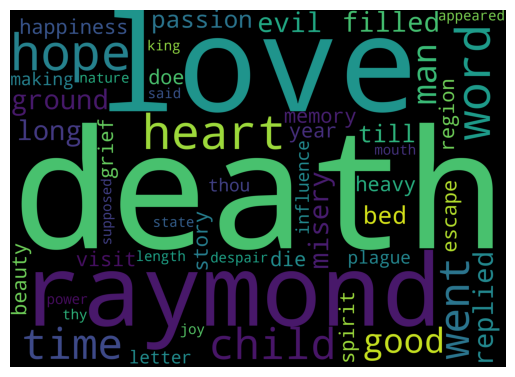

In [92]:
# SECOND TOPIC
secondcloud = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          width=2500,
                          height=1800
                         ).generate(" ".join(second_topic_words))
plt.imshow(secondcloud)
plt.axis('off')
plt.show()

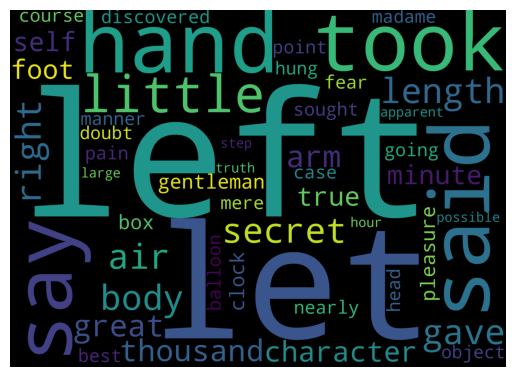

In [93]:
# THIRD TOPIC
thirdcloud = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          width=2500,
                          height=1800
                         ).generate(" ".join(third_topic_words))
plt.imshow(thirdcloud)
plt.axis('off')
plt.show()

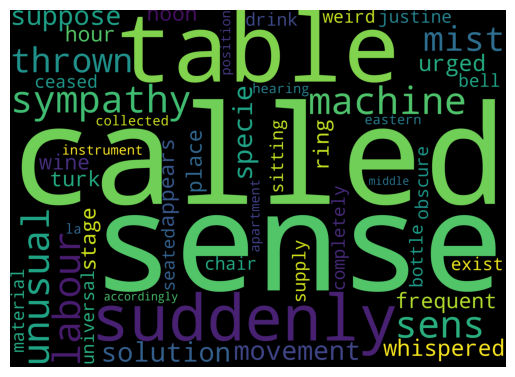

In [94]:
# FOURTH TOPIC
fourthcloud = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          width=2500,
                          height=1800
                         ).generate(" ".join(fourth_topic_words))
plt.imshow(fourthcloud)
plt.axis('off')
plt.show()